In [112]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from constants import SUBJECTS, ELECTRODES, FEATURE_FILENAME, RESULTS_FOLDER
from configs import configs

In [113]:
features = pd.read_csv(RESULTS_FOLDER / FEATURE_FILENAME)
print(features.shape)

threshold = 4 #in std
features.loc[:,ELECTRODES] = features.loc[:,ELECTRODES][features.loc[:,ELECTRODES]<threshold]
features = features.dropna()
print(features.shape)
features = features[features['game'] != '-']
#features = features[features['band'] != 'beta']

(53202, 14)
(52330, 14)


In [129]:
import math
import scipy

electrodes = ['T7', 'O1', 'C1', 'Fp1', 'O2', 'C2', 'Fp2', 'T8']

features['fron'] = (features['Fp1'] + features['Fp2'])/2
features['occ'] = (features['O1'] + features['O2'])/2
features['par'] = (features['C1'] + features['C2'])/2

features['all'] = features[electrodes].mean(axis=1)


def determine_signif(p,thresh):
    if p < thresh*1e-2:
        return "***"
    if p < thresh*1e-1:
        return "**"
    if p < thresh:
        return "*"
    else:
        return '-'

def minigame_stats(games, feature, thresh=0.05, d='greater'):
    
    version1 = games[games["difficulty"] == "1"]
    version2 = games[games["difficulty"] == "2"]
    version3 = games[games["difficulty"] == "3"]

    v1_v2_challenge_pvalue = scipy.stats.ttest_ind(version2[feature], version1[feature],
                                                  alternative=d)[1]
    v1_v3_challenge_pvalue = scipy.stats.ttest_ind(version3[feature], version1[feature],
                                                  alternative=d)[1]
    
    sign = '<' if d == 'less' else '>'

    return pd.Series({"baseline":version1[feature].mean(),
                      "mechanical":version3[feature].mean(),
                      "visual":version2[feature].mean(),
                      "test-mech": determine_signif(v1_v3_challenge_pvalue,thresh),
                      "test-vis": determine_signif(v1_v2_challenge_pvalue,thresh),
                     })

num_tests = 4
thresh = 1-math.pow(1-0.05,1/num_tests)

style_dic = {'baseline': "{:.3f}",
             'visual': "{:.3f}",
             'mechanical': "{:.3f}"
            }

for dire in ['greater', 'less']:
    if dire == 'less':
        band = 'alpha'
    else:
        band = 'gamma'

    test = features.groupby(['game','band']).apply(lambda x: minigame_stats(x,'fron',thresh=thresh,d=dire))
    df = test.reset_index()
    df = df[df['band'] == band]
    df = df.drop(columns='band')
    df.reset_index(drop=True)
    print(df.style.hide(axis="index").format(style_dic).to_latex(caption=f'{band} band power',
                                                                 label=f'{band}_data',
                                                                 position='h'))

\begin{table}[h]
\caption{gamma band power}
\label{gamma_data}
\begin{tabular}{lrrrll}
game & baseline & mechanical & visual & test-mech & test-vis \\
DOBBLE & -0.042 & 0.045 & 0.003 & *** & * \\
FLAPPY & -0.284 & -0.184 & -0.274 & *** & - \\
RUNSHOOT & -0.091 & -0.018 & -0.038 & *** & ** \\
SORTER & 0.068 & 0.128 & -0.003 & *** & - \\
\end{tabular}
\end{table}

\begin{table}[h]
\caption{alpha band power}
\label{alpha_data}
\begin{tabular}{lrrrll}
game & baseline & mechanical & visual & test-mech & test-vis \\
DOBBLE & 0.104 & 0.080 & 0.046 & - & * \\
FLAPPY & -0.213 & -0.173 & -0.218 & - & - \\
RUNSHOOT & -0.156 & -0.140 & -0.134 & - & - \\
SORTER & -0.009 & -0.033 & 0.045 & - & - \\
\end{tabular}
\end{table}



In [121]:
gameplay_quest = pd.read_csv("../Raw/subject_data.csv")
gameplay_quest["Challenge"] = gameplay_quest[["Q1", "Q2", "Q3", "Q4"]].sum(axis=1)

In [127]:
def determine_signif(p,thresh):
    if p < thresh*1e-2:
        return "***"
    if p < thresh*1e-1:
        return "**"
    if p < thresh:
        return "*"
    else:
        return '-'

def minigame_stats(games, feature="Challenge", thresh=0.05):
    
    version1 = games[games["Version"] == 1]
    version2 = games[games["Version"] == 2]
    version3 = games[games["Version"] == 3]

    v1_v2_challenge_pvalue = scipy.stats.ttest_ind(version2[feature], version1[feature])[1]
    v1_v3_challenge_pvalue = scipy.stats.ttest_ind(version3[feature], version1[feature])[1]

    return pd.Series({"baseline":version1[feature].mean(),
                      "mechanical":version3[feature].mean(),
                      "visual":version2[feature].mean(),
                      "test-mech": determine_signif(v1_v3_challenge_pvalue,thresh),
                      "test-vis": determine_signif(v1_v2_challenge_pvalue,thresh),
                     })

num_tests = 2
thresh = 1-math.pow(1-0.05,1/num_tests)

style_dic = {'baseline': "{:.3f}",
             'visual': "{:.3f}",
             'mechanical': "{:.3f}"
            }


test = gameplay_quest.groupby(by=['MiniGame']).apply(lambda x: minigame_stats(x,thresh=thresh))
df = test.reset_index()
df = df.rename(columns={"MiniGame": "game"})
df.reset_index(drop=True)
print(df.style.hide(axis="index").format(style_dic).to_latex(caption='Perceived difficulty score',
                                                             label='questionnaire_data',position='h'))

\begin{table}[h]
\caption{Perceived difficulty score}
\label{questionnaire_data}
\begin{tabular}{lrrrll}
game & baseline & mechanical & visual & test-mech & test-vis \\
DOBBLE & 14.292 & 14.958 & 13.667 & - & - \\
FLAPPY & 10.083 & 10.875 & 10.417 & - & - \\
RUNSHOOT & 12.417 & 14.667 & 11.750 & * & - \\
SORTER & 13.333 & 15.042 & 12.542 & - & - \\
\end{tabular}
\end{table}



In [8]:
counted = df.groupby(['id','difficulty','game']).count().reset_index()
counted

,id,difficulty,game,session,band,timestep,T7,O1,C1,Fp1,O2,C2,Fp2,T8
0,D43TCP,1,DOBBLE,6,6,6,6,6,6,6,6,6,6,6
1,D43TCP,1,FLAPPY,6,6,6,6,6,6,6,6,6,6,6
2,D43TCP,1,RUNSHOOT,6,6,6,6,6,6,6,6,6,6,6
3,D43TCP,1,SORTER,6,6,6,6,6,6,6,6,6,6,6
4,D43TCP,2,DOBBLE,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,lionheart123,2,SORTER,6,6,6,6,6,6,6,6,6,6,6
128,lionheart123,3,DOBBLE,6,6,6,6,6,6,6,6,6,6,6
129,lionheart123,3,FLAPPY,6,6,6,6,6,6,6,6,6,6,6
130,lionheart123,3,RUNSHOOT,6,6,6,6,6,6,6,6,6,6,6


In [7]:
sid = 'D43TCP'
counted[counted['id'] == sid]

,id,difficulty,game,session,band,timestep,T7,O1,C1,Fp1,O2,C2,Fp2,T8
0,D43TCP,1,DOBBLE,6,6,6,6,6,6,6,6,6,6,6
1,D43TCP,1,FLAPPY,6,6,6,6,6,6,6,6,6,6,6
2,D43TCP,1,RUNSHOOT,6,6,6,6,6,6,6,6,6,6,6
3,D43TCP,1,SORTER,6,6,6,6,6,6,6,6,6,6,6
4,D43TCP,2,DOBBLE,6,6,6,6,6,6,6,6,6,6,6
5,D43TCP,2,FLAPPY,6,6,6,6,6,6,6,6,6,6,6
6,D43TCP,2,RUNSHOOT,6,6,6,6,6,6,6,6,6,6,6
7,D43TCP,2,SORTER,6,6,6,6,6,6,6,6,6,6,6
8,D43TCP,3,DOBBLE,6,6,6,6,6,6,6,6,6,6,6
9,D43TCP,3,FLAPPY,6,6,6,6,6,6,6,6,6,6,6


In [38]:
np.unique([1,2,3])

array([1, 2, 3])

In [12]:
frontal = ['Fp1','Fp2']
df.loc[:, frontal]

,Fp1,Fp2
0,0.084559,0.096165
1,-0.441948,-0.278978
2,0.237951,0.319066
3,-0.041619,0.147453
4,-0.744258,-0.726988
...,...,...
670,-0.072526,-0.167875
671,0.887480,0.842899
672,-0.147586,-0.153561
673,-0.135300,-0.094773


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (11,) and arg 1 with shape (0,).

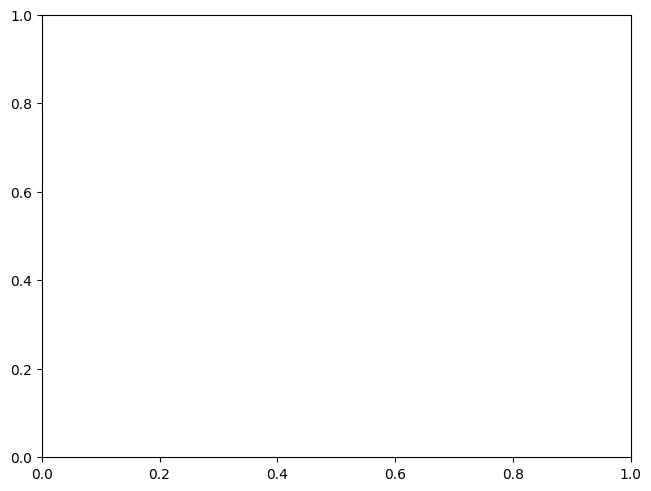

In [9]:
df = features.groupby(['id','difficulty','band']).mean(numeric_only=True).reset_index()

outside = df['id'].unique()

electrodes = ELECTRODES

frontal = ['Fp1','Fp2']
occipital = ['O1','O2']


# Make a grouped bar chart for each band
for band in configs['bands']:
    band_df = df[df['band'] == band]
    gmeas = {}
    # avg over electrodes axis=1
    easy = band_df.loc[band_df["difficulty"] == 1, electrodes].reset_index(drop=True).mean(axis=1)
    for difficulty in [2,3]:
        power = band_df.loc[band_df["difficulty"] == difficulty, electrodes].reset_index(drop=True).mean(axis=1)
        difference = power - easy 
        gmeas[difficulty] = difference.values
        #gmeas[difficulty] = power.values.mean(axis=1)

    x = np.arange(len(outside))  # the label locations
    width = 0.4  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for diffs in gmeas.keys():
        offset = width * multiplier
        measurement = gmeas[diffs]
        rects = ax.bar(x + offset, measurement, width, label=diffs)
        #ax.bar_label(rects, padding=4)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('power')
    ax.set_title(band)
    ax.set_xticks(x + width, np.arange(len(outside)))
    ax.legend(loc='upper left', ncols=3)



In [20]:
features

,game,difficulty,session,id,timestep,band,T7,O1,C1,Fp1,O2,C2,Fp2,T8,frontal
1,FLAPPY,2,1,GD5JC6,1,alpha,0.470979,-0.173613,0.679005,0.353152,-0.066132,0.638708,0.994024,2.855509,0.673588
2,FLAPPY,2,1,GD5JC6,2,alpha,0.847028,0.708708,0.871579,0.633172,-0.566584,0.984903,1.536408,2.285105,1.084790
3,FLAPPY,2,1,GD5JC6,3,alpha,-0.143859,-0.825975,-0.420075,-0.368376,-1.226576,-0.147982,-0.110520,2.192609,-0.239448
4,FLAPPY,2,1,GD5JC6,4,alpha,-0.391800,-1.224113,-0.988103,-0.873742,-0.696888,-1.027951,-0.930491,2.644530,-0.902117
5,FLAPPY,2,1,GD5JC6,5,alpha,0.035437,0.770818,-0.290145,0.436210,0.905190,-0.426673,-0.629458,1.905027,-0.096624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59527,FLAPPY,2,2,PizzaSlice,1793,gamma,-0.049430,-0.051362,-0.047648,-0.048129,-0.058185,-0.047963,-0.052529,-0.048398,-0.050329
59528,FLAPPY,2,2,PizzaSlice,1794,gamma,-0.047355,-0.050244,-0.045622,-0.045568,-0.055942,-0.045082,-0.050991,-0.047170,-0.048280
59529,FLAPPY,2,2,PizzaSlice,1795,gamma,-0.041768,-0.045098,-0.039838,-0.039812,-0.050167,-0.039610,-0.043730,-0.040346,-0.041771
59530,FLAPPY,2,2,PizzaSlice,1796,gamma,0.332279,0.329199,0.323075,0.323508,0.325660,0.322847,0.321464,0.319527,0.322486


0.025320565519103666


baseline    visual  mechanic  vis-base  mech-base
game     band                                                    
DOBBLE   alpha  0.047173  0.061090  0.083154     False      False
         gamma -0.092109 -0.036793 -0.012487      True       True
FLAPPY   alpha -0.373732 -0.376879 -0.242515     False       True
         gamma -0.335723 -0.341022 -0.209904     False       True
RUNSHOOT alpha -0.215456 -0.227837 -0.167164     False       True
         gamma -0.086710 -0.046005  0.039434      True       True
SORTER   alpha  0.001969  0.077443 -0.005749      True      False
         gamma  0.105561  0.055498  0.175627      True       True

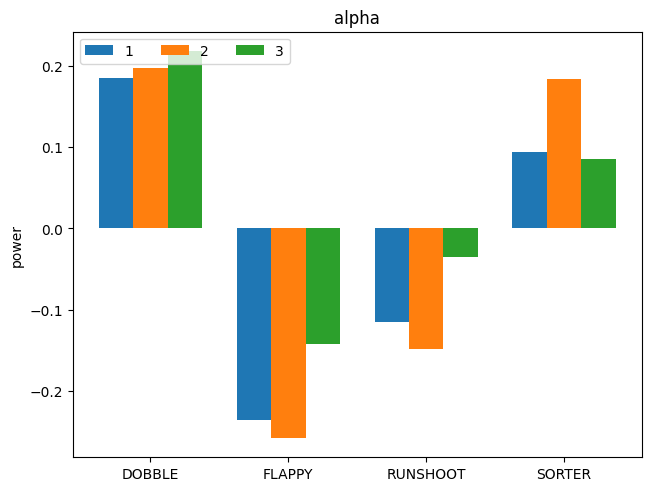

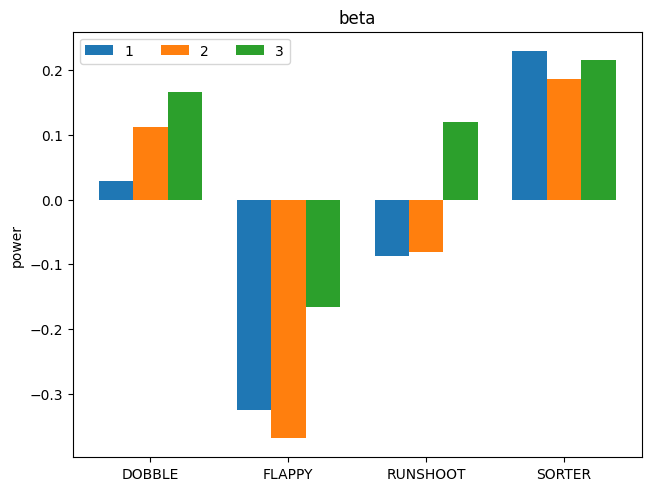

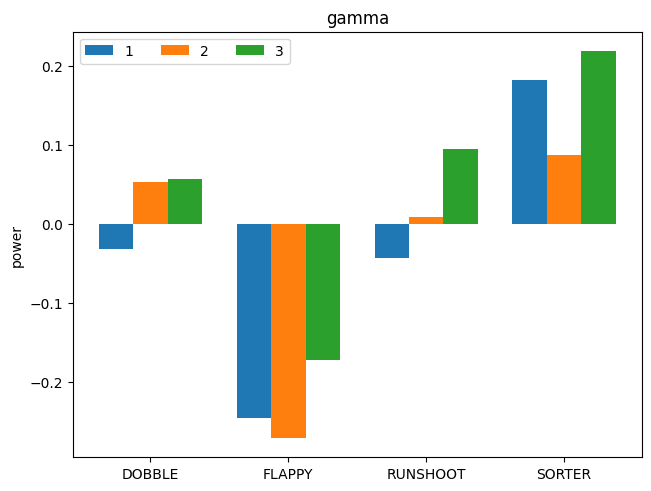

In [12]:
df = features.groupby(['game','difficulty','band']).mean(numeric_only=True).reset_index()

outside = df['game'].unique()

electrodes = ELECTRODES

frontal = ['Fp1','Fp2']
occipital = ['O1','O2']


# Make a grouped bar chart for each band
for band in configs['bands']:
    band_df = df[df['band'] == band]
    gmeas = {}
    # avg over electrodes axis=1
    for difficulty in [1,2,3]:
        power = band_df.loc[band_df["difficulty"] == str(difficulty), electrodes].reset_index(drop=True).mean(axis=1)
        gmeas[difficulty] = power

    x = np.arange(len(outside))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for diffs in gmeas.keys():
        offset = width * multiplier
        measurement = gmeas[diffs]
        rects = ax.bar(x + offset, measurement, width, label=diffs)
        #ax.bar_label(rects, padding=4)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('power')
    ax.set_title(band)
    ax.set_xticks(x + width, outside)
    ax.legend(loc='upper left', ncols=3)
